In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append("/content/drive/MyDrive/src")

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm

import matplotlib.pyplot as plt

from modules import *
from losses import *
from utils import random_binary_mask, get_synthetic_dataset, plot_synthetic_dataset,cosine_scheduler

In [4]:
# transform = transforms.Compose(
#     [transforms.Resize(28),
#      transforms.ToTensor()]
# )

# mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=transform)
# mnist_loader = DataLoader(mnist_train, BATCH_SIZE, shuffle=True)

In [5]:
synthetic_X, synthetic_y = get_synthetic_dataset()

normalized_synthetic_X = (synthetic_X - synthetic_X.min()) / (synthetic_X.max() - synthetic_X.min())

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
synthetic_dataset = TensorDataset(synthetic_X, synthetic_y)

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


AE Training finished!


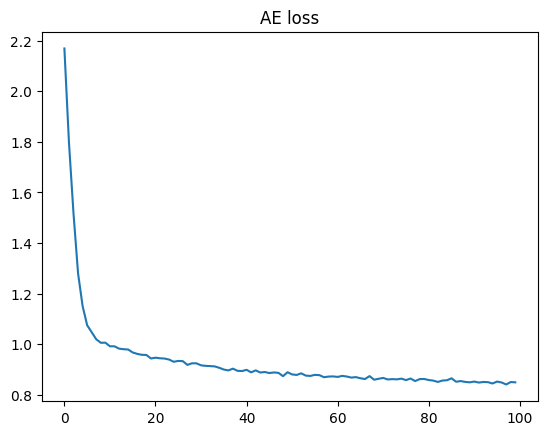

In [8]:
synthetic_layer_dims = [13, 10, 8]

BATCH_SIZE = 32
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=BATCH_SIZE, shuffle=True)

ae = MLPAutoEncoder(synthetic_layer_dims)
criterion = SparseLoss(pretrain=True)

ae = ae.to(device)

LR = 1e-3
EPOCHS = 100

optimizer = optim.Adam(ae.parameters(), lr=LR)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0

    for x, y in synthetic_dataloader:

        x = x.to(device)

        x_hat = ae(x)

        input_noise_mask = random_binary_mask(x.size(), x.device, type_mask="INPUT")
        x_input_noised_hat = ae(x * input_noise_mask)

        h = ae.encoder(x)
        h_noise = random_binary_mask(h.size(), h.device, type_mask="LATENT")
        h = h * h_noise
        x_latent_noised_hat = ae.decoder(h)

        loss = criterion(x, x_hat, x_input_noised_hat, x_latent_noised_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(synthetic_dataloader)
    losses.append(avg_epoch_loss)

print('AE Training finished!')
plt.plot(losses)
plt.title("AE loss")
plt.show()

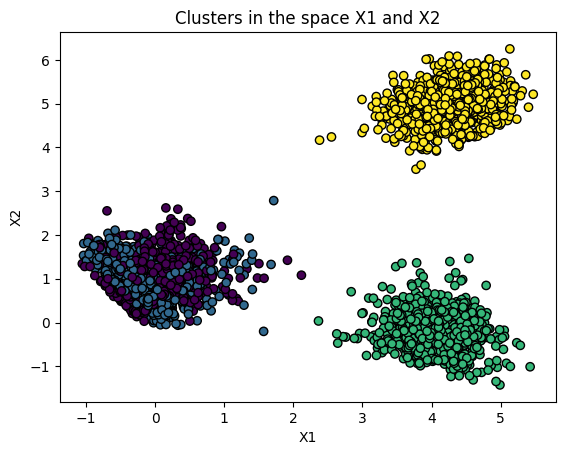

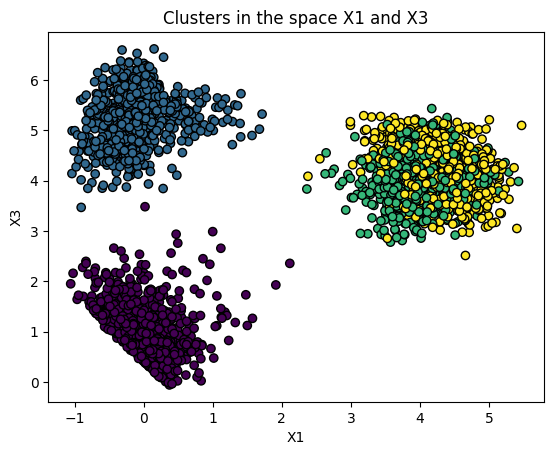

In [9]:
synthetic_X_hat = ae(synthetic_X.to(device))
plot_synthetic_dataset(synthetic_X_hat.cpu().detach().numpy(), synthetic_y)

100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


ALL Training finished!


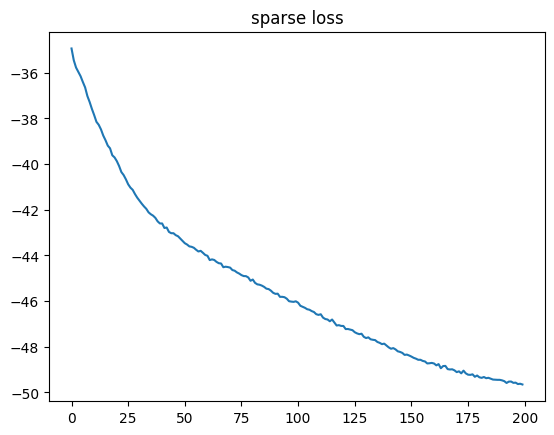

In [10]:
BATCH_SIZE = 32
synthetic_dataloader = DataLoader(synthetic_dataset, batch_size=BATCH_SIZE, shuffle=True)

gnn = GatingNN(13, 16)
gnn = gnn.to(device)

LR = 1e-3
EPOCHS = 200

optimizer = optim.Adam(list(gnn.parameters()) + list(ae.parameters()), lr=LR)
criterion = SparseLoss(pretrain=False)
losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    lmbd = cosine_scheduler(epoch, EPOCHS)

    for x, y in synthetic_dataloader:


        x = x.to(device)

        x_z, z, u = gnn(x)
        x_hat = ae(x)
        x_z_hat = ae(x_z)

        input_noise_mask = random_binary_mask(x.size(), x.device, type_mask="INPUT")
        x_input_noised_hat = ae(x * input_noise_mask)

        h = ae.encoder(x)
        h_noise = random_binary_mask(h.size(), h.device, type_mask="LATENT")
        h = h * h_noise
        x_latent_noised_hat = ae.decoder(h)

        loss = criterion(x, x_hat, x_input_noised_hat, x_latent_noised_hat,x_z_hat,z,u,lmbd)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(synthetic_dataloader)
    losses.append(avg_epoch_loss)

print('ALL Training finished!')
plt.plot(losses)
plt.title("sparse loss")
plt.show()

In [11]:
X = synthetic_X.to(device)
X_Z ,z , _ = gnn(X)
H = ae.encoder(X_Z)

In [12]:
cluster_dataset = TensorDataset(X_Z, H, synthetic_y)

BATCH_SIZE = 32
cluster_dataloader = DataLoader(cluster_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 50/50 [00:50<00:00,  1.00s/it]


ClusterHead Training finished!


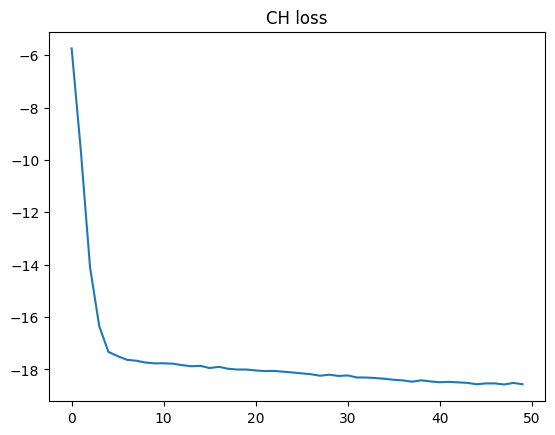

In [13]:
clust = ClusteringNN(13,8, 2, 4, tau=10)
criterion = ClusterLoss(4)

clust = clust.to(device)

LR = 1e-3
EPOCHS = 50

LR_ZG = 1e-1

params = list(clust.parameters())

# Enlever ZG
optimizer = optim.Adam(params[:-1], lr=LR)

optimizer_ZG = optim.SGD([params[-1]], lr=LR_ZG)

losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = 0.0
    lmbd = cosine_scheduler(epoch, EPOCHS)


    for x, h, y in cluster_dataloader:

        x = x.to(device)
        h = h.to(device)
        y = y.to(device)

        clust_logits, aux_logits, u_zg = clust(x, h)
        loss = criterion(h, clust_logits, aux_logits, u_zg, lmbd)

        optimizer.zero_grad()
        optimizer_ZG.zero_grad()

        loss.backward(retain_graph=True)

        optimizer.step()
        optimizer_ZG.step()

        epoch_loss += loss.item()

    # Save the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(cluster_dataloader)
    losses.append(avg_epoch_loss)

print('ClusterHead Training finished!')
plt.plot(losses)
plt.title("CH loss")
plt.show()

In [20]:
X = synthetic_X.to(device)
X_Z ,z , _ = gnn(X)
H = ae.encoder(X_Z)

clust_logits, aux_logits, u_zg = clust(X_Z, H)
yhat = clust_logits.argmax(dim=1).cpu()

In [19]:
(yhat == synthetic_y).float().mean()

tensor(0.2500)

In [28]:
clust_logits

tensor([[9.9854e-01, 7.2541e-04, 2.2609e-04, 5.0366e-04],
        [9.9835e-01, 1.1825e-03, 1.6693e-04, 2.9892e-04],
        [9.9632e-01, 1.6999e-03, 7.0948e-04, 1.2700e-03],
        ...,
        [1.0000e+00, 1.1480e-06, 1.9696e-07, 6.5705e-07],
        [1.0000e+00, 1.5084e-06, 2.1876e-07, 6.5457e-07],
        [9.9998e-01, 1.0060e-05, 2.1972e-06, 5.0060e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [30]:
clust_logits.argmax(1)

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')